In [157]:
import os
import re
import json
import spacy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacy import displacy
from read_problems import read_questions_json
from read_problems import read_all_problems
from read_problems import write_problems
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer

%matplotlib inline

In [801]:
class QuestionCategory(object):
    # The subject of the question is the definition and
    # the choices contain the potential technical term associated to it
    DEF_KEYWORD = 0
    # The subject of the question is the definition and
    # the rest of the question contains the beginning of the technical term
    # and the choices contain the potential end of the technical term
    DEF_KEYWORD_START_END = 1
    
    # The subject of the question is a technical term or very close to it and
    # the proposed choices are the potential definitions of the technical term
    KEYWORD_DEF = 2
    # The subject of the question is a technical term or very close to it and
    # the rest of the question contains the beginning or a good part of the definition and
    # the choices contain the end of the definition
    KEYWORD_DEF_START_END = 3
    
    # The subject of the question is a characteristic and 
    # the proposed choices are the potential technical terms exposing this characteristic
    CHAR_KEYWORD = 4
    # The subject of the question is a technical term and 
    # the proposed choices are the potential characteristics associated with this characteristic
    KEYWORD_CHAR = 5
    
    # The question is quite complex. The subject of the description refers to a previous sentence in the question
    SITUATION_KEYWORD = 6
    
    # Very hard
    KEYWORD_COMPARISON = 7
    CALCULUS = 8
    REASONING = 9
    BEST_ASSOCIATION = 10
    
    # Will probably never care
    OCR_PROBLEM = 20
    
    UNLABELED = 666

In [374]:
def get_enum_name(enum_class, enum_value):
    enum_names = {value: name for name, value in vars(enum_class).items() if name.isupper()}
    return enum_names[enum_value]

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [152]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en')
wiki_nlp = spacy.load('xx_ent_wiki_sm')

In [895]:
def load_glossary():
    path = os.path.join('..', 'Data', 'material_handbook', 'glossary_manual.json')
    return json.load(open(path))

def calculate_average_question_len(q):
    res = q['choice_A_len'] + \
          q['choice_B_len'] + \
          q['choice_C_len']
    if q['choice_D'] is np.NaN:
        return res / 3
    res += q['choice_D_len']
    return res / 4

def add_length_features(df):
    df['question_len'] = df['question'].str.len()
    df['choice_A_len'] = df['choice_A'].str.len()
    df['choice_B_len'] = df['choice_B'].str.len()
    df['choice_C_len'] = df['choice_C'].str.len()
    df['choice_D_len'] = df['choice_D'].str.len()
    df['average_question_len'] = df.apply(calculate_average_question_len, axis=1)
    df['question_choice_len_ratio'] = df['question_len'] / df['average_question_len']

def is_roman(word):
    return re.match('^[IVXLC]+$', word) is not None

def get_keyword(term):
    words = term.split(' ')
    words = [x.lower() for x in words if is_roman(x) or x.lower() not in STOP_WORDS]
    return ' '.join(words)

def is_in_glossary(term, glossary):
    if term is np.NaN:
        return False
    keyword = term
    if keyword not in glossary:
        keyword = get_keyword(term)
    return keyword in glossary
    
def sentence_with_term(sentence, glossary):
    if sentence is np.NaN:
        return False
    for keyword, definition in glossary.items():
        if keyword.lower() in sentence.lower():
            return True
    return False

def any_choice_in_glossary(df):
    if df['choice_D'] is np.NaN:
        return df['choice_A_in_glossary'] or \
               df['choice_B_in_glossary'] or \
               df['choice_C_in_glossary']
    return df['choice_A_in_glossary'] or \
           df['choice_B_in_glossary'] or \
           df['choice_C_in_glossary'] or \
           df['choice_D_in_glossary']

def add_glossary_features(df):
    glossary = load_glossary()
    df['choice_A_in_glossary'] = df['choice_A'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_B_in_glossary'] = df['choice_B'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_C_in_glossary'] = df['choice_C'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_D_in_glossary'] = df['choice_D'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['any_choice_in_glossary'] = df.apply(any_choice_in_glossary, axis=1)
    df['choice_q_keywords'] = df.apply(extract_choice_query_keywords, axis=1)
    df['choice_with_q_subject_in_glossary'] = df.apply(lambda p: choice_with_q_subject_in_glossary(p, glossary), axis=1)

def has_numbers(problem):
    question = problem['question']
    for token in problem['question_nlp']:
        if re.match("^[0-9]+[.,]?[0-9]+$", str(token)) is not None:
            return True
    return False

def has_numbers_nlp(problem):
    question = problem['question']
    for token in problem['question_nlp']:
        if token.is_digit:
            return True
    return False

def get_ner(problem, nlp_q):
    question = problem['question']
    ent_type_ids = set()
    ent_types = []
    for token in problem[nlp_q]:
        if token.ent_type != 0 and token.ent_type not in ent_type_ids:
            ent_type_ids.add(token.ent_type)
            ent_types.append(token.ent_type_)
    if len(ent_types) == 0:
        return None
    return ent_types

def get_verb_centrality(problem):
    index = -1
    for i, token in enumerate(problem['question_nlp']):
        t = str(token)
        if t == 'defined' or t == 'described':
            index = i
            break
    if index == -1:
        return -1
    nb_tokens = len(problem['question_nlp'])
    res = (index + 1) / nb_tokens
    if nb_tokens % 2 == 1:
        res -= 1 / (2 * nb_tokens)
    return res

def has_ner(problem):
    ent_types = problem['question_ner']
    return ent_types is not None and ('PERSON' in ent_types or 'PERCENT' in ent_types)

def get_definition_subject(problem):
    question = problem['question']
    q_nlp = nlp(question, disable=['ner', 'textcat'])
    subject = []
    for token in reversed(q_nlp):
        if token.pos != VERB or not is_def_word(token.text):
            continue
        while token != token.head:
            token = token.head
        for child in token.children:
            if child.dep != nsubj and child.dep != nsubjpass:
                continue            
            subtree = list(child.subtree)
            if subtree[0].dep == det:
                subtree = subtree[1:]
            return ''.join(map(lambda x: x.text_with_ws, subtree))
    return ''

def extract_choice_query_keywords(problem):
    subject = get_definition_subject(problem)
    choiceA = (problem['choice_A'] + ' ' + subject).strip()
    choiceB = (problem['choice_B'] + ' ' + subject).strip()
    choiceC = (problem['choice_C'] + ' ' + subject).strip()
    if 'choice_D' not in problem or problem['choice_D'] is np.NaN:
        return (choiceA, choiceB, choiceC)
    choiceD = (problem['choice_D'] + ' ' + subject).strip()
    return (choiceA, choiceB, choiceC, choiceD)

def choice_with_q_subject_in_glossary(problem, glossary):
    keywords = problem['choice_q_keywords']
    for keyword in keywords:
        if is_in_glossary(keyword, glossary):
            return True
    return False

def add_features(nlp, wiki_nlp, df):
    add_length_features(df)
    add_glossary_features(df)
    df['question_nlp'] = df['question'].apply(lambda q: nlp(q))
    df['question_wiki_nlp'] = df['question'].apply(lambda q: wiki_nlp(q))
    df['question_has_digits'] = df.apply(has_numbers, axis=1)
    df['question_has_digits_nlp'] = df.apply(has_numbers_nlp, axis=1)
    df['question_ner'] = df.apply(lambda p: get_ner(p, 'question_nlp'), axis=1)
    df['question_has_ner'] = df.apply(has_ner, axis=1)
    df['question_verb_centrality'] = df.apply(get_verb_centrality, axis=1)

def predict(df, category, filters_factory):
    df.loc[filters_factory(df), 'predicted_category'] = category

def clean_features(df):
    df.drop(['question_len', 'choice_A_len', 'choice_B_len', 'choice_C_len', 'choice_D_len', 'average_question_len', 'filename', 'comments', 'choice_A_in_glossary', 'choice_B_in_glossary', 'choice_C_in_glossary', 'choice_D_in_glossary'], axis=1, inplace=True)
    
def predict_category(category, filters_factory, with_df=None):
    if with_df is None:
        df = read_all_problems()
        df['real_category'] = all_df['category'].copy()
        add_features(nlp, wiki_nlp, df)
    else:
        df = with_df
        df['category'] = all_df['real_category'].copy()

    df['predicted_category'] = QuestionCategory.UNLABELED
    filters = df['category'] != category
    df.loc[filters, 'category'] = QuestionCategory.UNLABELED

    predict(df, category, filters_factory)

    y_pred = df['predicted_category']
    y_test = df['category']
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), [get_enum_name(QuestionCategory, category), 'OTHER'])
    print(classification_report(y_test, y_pred))
    
    return df

Confusion matrix, without normalization
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
        666       1.00      0.98      0.99      2086

avg / total       1.00      0.98      0.99      2086



/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


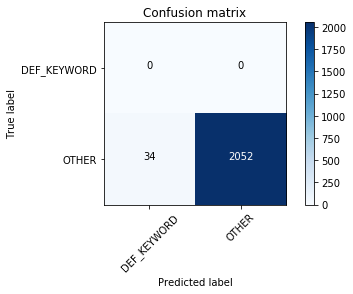

In [902]:
def get_def_keyword_filters_base(df):
    filters = ~df['question'].str.contains(', CFA,')
    filters &= (df['question'].str.contains('described as') |
               df['question'].str.contains('defined as'))
    filters &= df['question_choice_len_ratio'] < 27.0
    filters &= df['question_verb_centrality'] > 0.6
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_ner']
    return filters

def get_def_keyword_filters(df):
    filters = get_def_keyword_filters_base(df)
    filters &= df['any_choice_in_glossary']
    return filters

all_df = predict_category(QuestionCategory.DEF_KEYWORD, get_def_keyword_filters, all_df)

Confusion matrix, without normalization
             precision    recall  f1-score   support

          1       0.25      0.40      0.31         5
        666       1.00      1.00      1.00      2081

avg / total       1.00      1.00      1.00      2086



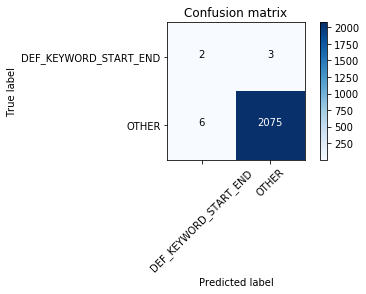

In [903]:
def get_def_keyword_start_end_filters(df):
    filters = get_def_keyword_filters_base(df)
    filters &= df['choice_with_q_subject_in_glossary']
    return filters

all_df = predict_category(QuestionCategory.DEF_KEYWORD_START_END, get_def_keyword_start_end_filters)

In [ ]:
def get_keyword_def(df):
    filters = get_def_keyword_filters_base(df)
    filters &= df['choice_with_q_subject_in_glossary']
    return filters

all_df = predict_category(QuestionCategory.DEF_KEYWORD_START_END, get_def_keyword_start_end_filters)

In [859]:
all_df.loc[26, 'question']

'If an analyst estimates the probability of an event for which there is no historical record, this probability is best  described as:'

In [873]:
from spacy.symbols import nsubj, VERB, root, nsubjpass, det

def is_def_word(word):
    return word == 'described' or word == 'defined'

def get_def_index(words):
    for i in range(len(words)):
        if is_def_word(words[i]):
            break
    return i

def get_description_perimeter(problem):
    question = problem['question']
    words = question.split(' ')
    def_index = get_def_index(words)
    first_index = def_index - 6
    if first_index < 0:
        first_index = 0
    last_index = def_index + 6
    if last_index >= len(words):
        last_index = len(words)
    return ' '.join(words[first_index:last_index])

def get_definition_subject(problem):
    question = problem['question']
    q_nlp = nlp(question, disable=['ner', 'textcat'])
    subject = []
    for token in reversed(q_nlp):
        if token.pos != VERB or not is_def_word(token.text):
            continue
        while token != token.head:
            token = token.head
        for child in token.children:
            if child.dep != nsubj and child.dep != nsubjpass:
                continue            
            subtree = list(child.subtree)
            if subtree[0].dep == det:
                subtree = subtree[1:]
            return ''.join(map(lambda x: x.text_with_ws, subtree))
    return ''

def extract_keyword(problem):
    subject = get_definition_subject(problem)
    choiceA = problem['choice_A'] + ' ' + subject
    choiceB = problem['choice_B'] + ' ' + subject 
    choiceC = problem['choice_C'] + ' ' + subject
    if 'choice_D' not in problem or problem['choice_D'] is np.NaN:
        return (choiceA, choiceB, choiceC)
    choiceD = problem['choice_D'] + ' ' + subject
    return (choiceA, choiceB, choiceC, choiceD)

target = all_df[all_df['real_category'] == QuestionCategory.DEF_KEYWORD_START_END]
target = target.apply(extract_keyword, axis=1)

with pd.option_context('display.max_colwidth', 500):
    print(target)

26                                                                (a priori probability , objective probability , empirical probability , subjective probability )
375                                                                                       (a priori probability , empirical probability , subjective probability )
920                                                          (default risk investor’s fear , downgrade risk investor’s fear , credit spread risk investor’s fear )
1826    (a Student's t distribution of the future stock price , lognormal distribution of the future stock price , normal distribution of the future stock price )
1995                                                  (strong form of market efficiency , weak form of market efficiency , semi-strong form of market efficiency )
dtype: object


In [871]:
defs.loc[1995, 'question']

'If a test rejects the hypothesis that market prices reflect private information but does not reject the hypothesis that they reflect past market data and public information, then the form of market efficiency is best described as:'

In [570]:
def display_dependencies(sentence):
    doc = nlp(sentence)
    displacy.render(doc, style='dep', jupyter=True)
    
display_dependencies(defs.loc[1092, 'question'])

In [474]:
defs.loc[26, 'question']

'If an analyst estimates the probability of an event for which there is no historical record, this probability is best  described as:'

In [ ]:
def display_dependencies(sentence):
    doc = nlp(sentence)
    displacy.render(doc, style='dep', jupyter=True)

In [31]:
question = 'Which of the following statements regarding correlation and covariance is most likely correct? The correlation  between two random variables is their covariance standardized by the:'

def is_start_end_definition(question):
    match = re.match('^.*[.!?] The([^.!?]*) is [^.!?]*:$', question)
    return not match is None

def extract_last_sentence(question):
    match = re.match('^([^.!?]*[.!?:])+$', question)
    return match.group(1).strip()

extract_last_sentence(question)

'The correlation  between two random variables is their covariance standardized by the:'

In [551]:
test_df = read_all_problems()
test_defs = test_df[test_df['question'].str.contains("described") | test_df['question'].str.contains("defined")]
test_defs.drop(['comments'], axis=1, inplace=True)
test_defs[test_defs['category'] == QuestionCategory.OTHER]

/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,answer,category,choice_A,choice_B,choice_C,choice_D,filename,question,question_nb,topic,year
513,B,666,objective of financial reporting,general requirement for financial statements,qualitative characteristic of the IFRS Framework,NaN,2010_afternoon_answer.xml,Under International Financial Reporting Standards (IFRS) the preparation of a complete set of financial statements is best described as a(n):,50,Financial Statement Analysis,2010
517,C,666,the amount of proceeds received in exchange for the obligation,the discounted value of the future cash flows that are required to satisfy the obligation,the undiscounted amount of cash or cash equivalents expected to be paid to satisfy the obligation,NaN,2010_afternoon_answer.xml,The settlement value for a liability is best described as:,54,Financial Statement Analysis,2010
551,A,666,overvalued by $11.36,undervalued by $15.13,undervalued by $36.36,NaN,2010_afternoon_answer.xml,"A company’s $100 par perpetual preferred stock has a dividend rate of 7 percent and a required rate of return of 11 percent. The company’s earnings are expected to grow at a constant rate of 3 percent per year. If the market price per share for the preferred stock is $75, the preferred stock is most appropriately described as being:",88,Equity Investments,2010
555,C,666,loan to the futures trader,requirement set by federal regulators,down payment from the futures trader,NaN,2010_afternoon_answer.xml,Margin in the futures market is most accurately described as a:,92,Derivative Investments,2010
556,B,666,a return based on the return of another asset,an adjustment to another asset’s level of risk,an agreement between two parties to provide something for each other,NaN,2010_afternoon_answer.xml,A derivative is most accurately defined as a financial instrument that provides:,93,Derivative Investments,2010
654,B,666,equal for the two projects,lower for Project 1 than for Project 2,greater for Project 1 than for Project 2,NaN,2010_morning_answer.xml,"An analyst is developing net present value (NPV) profiles for two investment projects. The only difference between the two projects is that Project 1 is expected to receive larger cash flows early in the life of the project, while Project 2 is expected to receive larger cash flows late in the life of the project. The sensitivities of the projects’ NPVs to changes in the discount rate is best described as:",72,Corporate Finance,2010
848,B,666,H0: 9 = 90 versus Ha: 9 ^ 90,H0: 9 < 90 versus Ha: 9 > 90,H0: 9 > 90 versus Ha: 9 < 90,NaN,2011_morning_answer.xml,"When an investigator wants to test whether a particular parameter is larger than a specific value, the null and alternative hypothesis are best defined as:",29,Quantitative Methods,2011
852,B,666,fixed in the long run,variable in the long run,variable in the short run,NaN,2011_morning_answer.xml,"Regarding a company’s production function, both labor costs and capital costs are best described as:",34,Economics,2011
856,B,666,cost-push inflation,demand-pull inflation,monetarist cycle theory,NaN,2011_morning_answer.xml,Suppose inflation increases due to increases in government spending and a reduction in taxes. Such inflation is best described as:,38,Economics,2011
971,B,666,Qb and Qa,Qc and Qb,Qc and Qa,NaN,2012_afternoon_answer.xml,"The diagram illustrates a consumer's allocation of her budget between items X and Y. With an initial budget (BC1) she consumes Qa units of item Y. When the price of Y drops, she consumes Qc units of item Y. Lines BC2 and BC3 are parallel to one another. The income effect arising from this change in the price of Y is best described as the distance between:",34,Economics,2012


In [600]:
all_df.loc[513, 'question']

'Under International Financial Reporting Standards (IFRS) the preparation of a complete set of financial statements is best described as a(n):'

In [603]:
get_definition_subject(all_df.loc[513])

'[preparation, of, a, complete, set, of, financial, statements] => OTHER'

In [793]:
write_problems(all_df)

In [759]:
all_df.loc[336, 'question']

'An analyst is evaluating various debt securities issued by a company. The type of security that is most likely to yield the lowest recovery in a bankruptcy is a:'

In [799]:
all_df = read_all_problems()
filters = all_df['category'] == QuestionCategory.BEST_ASSOCIATION
all_df.loc[filters]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,topic,year
93,B,10,default on the forward contract,do nothing until the long makes payment,accept delivery of SP 500 stocks from the long,deliver the portfolio of SP 500 stocks to the ...,"""Forward Markets and Contracts,"" Don M. Chance...",2008_part_1.xml,Two parties agree to a forward contract to del...,94,Derivative Investments,2008
441,B,10,Default on the forward contract,Do nothing until the long makes payment,Accept delivery of S&P 500 stocks from the long,NaN,"“Forward Markets and Contracts”, Don M. Chance...",2009_morning_answers.xml,Two parties agree to a forward contract to del...,94,Derivative Investments,2009
513,B,10,objective of financial reporting,general requirement for financial statements,qualitative characteristic of the IFRS Framework,NaN,"“Financial Reporting Standards,” Thomas R. Rob...",2010_afternoon_answer.xml,Under International Financial Reporting Standa...,50,Financial Statement Analysis,2010
635,A,10,disclosure in a note or supplementary schedule,"outflow from investing activities, and an infl...","outflow from operating activities, and an infl...",NaN,"“Understanding the Cash Flow Statement,” Thom...",2010_morning_answer.xml,A company issued shares to acquire a large tra...,53,Financial Statement Analysis,2010
851,B,10,fixed in the long run,variable in the long run,variable in the short run,NaN,"“Output and Costs,” Michael Parkin 2011 Modula...",2011_morning_answer.xml,"Regarding a company’s production function, bot...",34,Economics,2011
924,C,10,Default risk,Liquidity risk,Prepayment risk,NaN,"“Overview of Bond Sectors and Instruments,” Fr...",2011_morning_answer.xml,The primary motivation for creating a collater...,108,Fixed Income Investments,2011
1353,C,10,timeliness and accrual accounting,understandability and verifiability,relevance and faithful representation,NaN,"""Financial Reporting Standards,"" Elaine Henry,...",2013_morning_answer.xml,According to the International Accounting Stan...,59,Financial Statement Analysis,2013
1568,A,10,publicly advocating for global accounting stan...,mandating that non-US issuers provide a reconc...,requiring issuers to provide disclosures descr...,NaN,The SEC now advocates for global accounting st...,2016_afternoon_question.xml,The SEC's approach to addressing the significa...,50,Financial Statement Analysis,2016
1618,B,10,high ability and willingness,high ability and low willingness,low ability and high willingness,NaN,Although the client owns a successful business...,2016_afternoon_question.xml,You are preparing an investment policy stateme...,111,Portfolio Management,2016
1757,C,10,financial position,comprehensive income,changes in equity,NaN,"""Financial Statement Analysis: An Introduction...",2014_morning.xml,The financial statement that would be most use...,51,Financial Statement Analysis,2014
